## Import and Load Relevant Packages and Utilities

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import filter_data, interpolate_missing_data, perform_rqa

## Lets run RQA analysis of a single file and plots the time-seres and RPs to do a visual check

Loading file: 402_GRP.csv


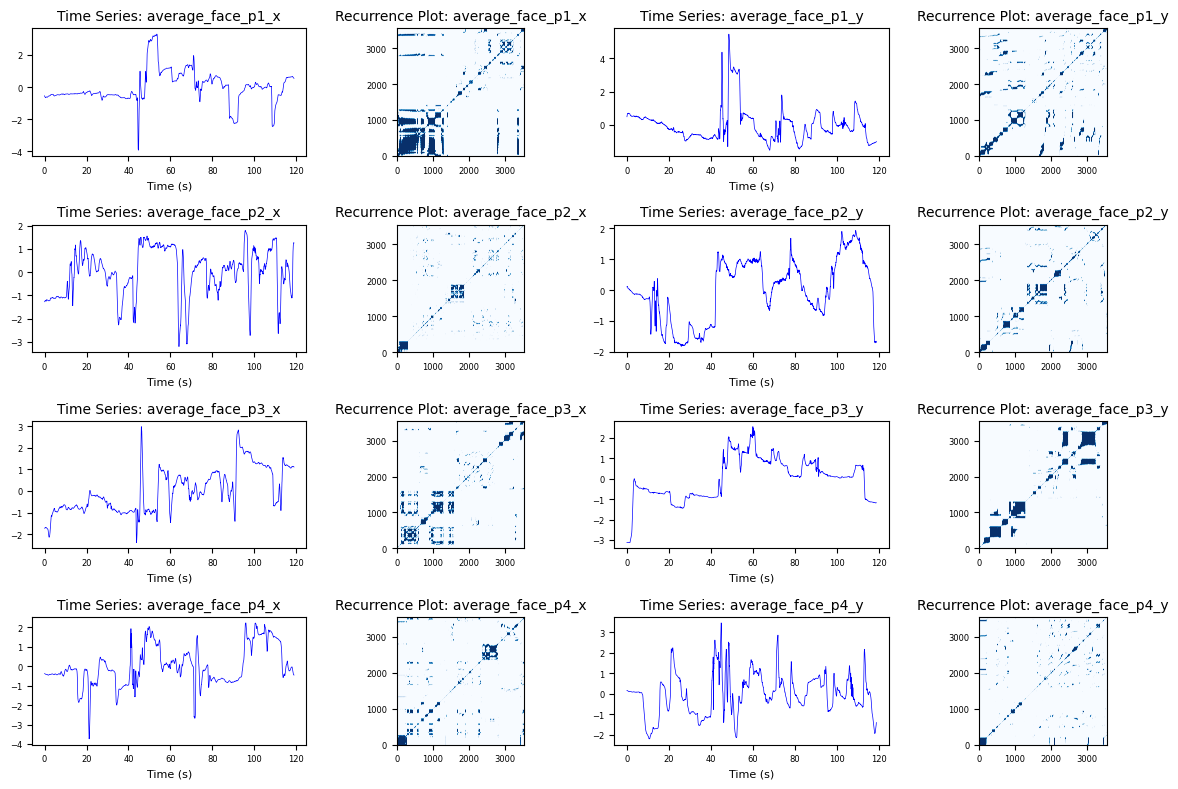

All files processed successfully!


In [6]:
# Set the directory path for the data
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

# save image (True) or not (False
save_image = True

# Get a valid participant number
part_number = 402  # Update this to the desired participant ID

# Get window size (number of frames to consider) as a function of frame rate (30 frames per second)
window_size = 30 * 120  # 2 minutes of data

# Initialize the plot with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Construct the filename and file path
filename = f"{part_number}_GRP.csv"
file_path = os.path.join(directory, filename)

# Check if the file exists
if os.path.exists(file_path):
    print(f'Loading file: {filename}')

    # List of columns to analyze
    columns = [
        'average_face_p1_x', 'average_face_p1_y',
        'average_face_p2_x', 'average_face_p2_y',
        'average_face_p3_x', 'average_face_p3_y',
        'average_face_p4_x', 'average_face_p4_y'
    ]
    
    # Load the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Select only the relevant columns and trim the data to the window size, removing the first 30 frames
    data = data[columns]
    data = data[30:window_size]

    # Interpolate missing data
    data = interpolate_missing_data(data)

    # Filter the data
    data = filter_data(data)
    
    # Z-score normalization
    data = (data - data.mean()) / data.std()

    # RQA parameters
    rqa_params = {
        'delay': 5,
        'embedding_dimension': 5,
        'radius': 0.25,
        'minLine': 3,
        'getRP': True
    }

    # Perform RQA and obtain the results
    rqa_results, rp_results = perform_rqa(data, **rqa_params)

    # Loop through each column to plot the time series and recurrence plots
    for idx, column in enumerate(columns):
        # Plot time series
        time = np.arange(len(data)) / 30  # Assuming data is at 30Hz
        axes[idx//2, (idx%2)*2].plot(time, data[column], color='blue', linewidth=0.5)
        axes[idx//2, (idx%2)*2].set_title(f'Time Series: {column}', fontsize=10)
        axes[idx//2, (idx%2)*2].set_xlabel('Time (s)', fontsize=8)
        axes[idx//2, (idx%2)*2].tick_params(axis='both', which='major', labelsize=6)

        # Plot recurrence plot
        axes[idx//2, (idx%2)*2 + 1].imshow(rp_results[column].recurrence_matrix, cmap='Blues', origin='lower')
        axes[idx//2, (idx%2)*2 + 1].set_title(f'Recurrence Plot: {column}', fontsize=10)
        axes[idx//2, (idx%2)*2 + 1].tick_params(axis='both', which='major', labelsize=6)

    # Adjust layout and save the plot
    plt.tight_layout()
    if save_image:
        image_name = filename.split('.')[0]
        plt.savefig(f'images/rqa/{filename}_rp_plot.png')
    plt.show()

    print('All files processed successfully!')
else:
    print(f'File {filename} not found in directory {directory}')


## Run a Windowed RQA analysis on the data for a given set of RQA parameters

In [9]:
# Set the directory path for the data
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

# Set the frame rate and window size in seconds
fps = 30
window_size_seconds = 120  # Set window size in seconds
window_size = int(window_size_seconds * fps)  # Calculate window size in frames
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Step size for windows

#print(f'Window size: {window_size} frames ({window_size_seconds} seconds)')
#print(f'Step size: {step_size} frames')

# Set the delay and ED parameters to iterate over
delays = [10, 20, 30, 60, 90]
embedding_dimensions = [3, 4, 5, 6]
radii = [0.05] #, 0.1, 0.15, 0.2, 0.3]

# Initialize a list to store results for the CSV
csv_results = []

# Get the number of CSV files in the directory
num_files = len([filename for filename in os.listdir(directory) if filename.endswith('.csv')])
index = 0

# loop over each delay and embedding dimension
for delay in delays:
    for ed in embedding_dimensions:
        for radius in radii:
            # Set the RQA parameters
            rqa_params = {
                'delay': delay,
                'embedding_dimension': ed,
                'radius': radius,
                'minLine': 5,
                'getRP': False
            }

            # Set the analysis parameters
            analysis_parameters = f"_windowSize{window_size_seconds}s_delay{rqa_params['delay']}_dim{rqa_params['embedding_dimension']}_radius{rqa_params['radius']}_minLine{rqa_params['minLine']}"

            # Iterate through each file in the directory
            for filename in os.listdir(directory):
                if filename.endswith('.csv'):
                    # Print hyperparameters
                    print(f'Hyperparameters: {rqa_params}')

                    # Process the files
                    file_path = os.path.join(directory, filename)

                    # Load the CSV file into a DataFrame
                    data = pd.read_csv(file_path)

                    # Update the progress
                    index += 1

                    # Get group number from filename
                    group_number = int(filename.split('_')[0])

                    # Get condition "group" = GRP or individual = IND from file name (before .csv)
                    condition = filename.split('_')[1]

                    # Select only the relevant columns
                    columns = [
                        'average_face_p1_x', 'average_face_p1_y',
                        'average_face_p2_x', 'average_face_p2_y', 
                        'average_face_p3_x', 'average_face_p3_y', 
                        'average_face_p4_x', 'average_face_p4_y'
                    ]

                    # Only use the specified columns
                    data = data[columns]

                    # Initialize result_row to store the average RQA metrics for this file
                    result_row = {
                        'filename': filename,
                        'group_number': group_number,
                        'condition': condition,
                        'num_windows': 0
                    }

                    # List to store metrics for all windows
                    all_metrics = []

                    #print(f'Processing file: {filename}')

                    # skipped windows index
                    skipped_windows_index = 0

                    # Iterate over the data in windows with 50% overlap
                    for start in range(0, len(data) - window_size + 1, step_size):
                        #print(f"Processed window starting at {start}")

                        # Get the window of data
                        window = data[start:start + window_size]

                        # Count the number of missing values in each column
                        missing_counts = window.isnull().sum()

                        # Check if there are more than 90 consecutive missing values in any column
                        if any(window.apply(lambda col: col.isnull().astype(int).groupby(col.notnull().astype(int).cumsum()).cumsum().max() > 90)):
                            print(f"Skipping window starting at {start} as it contains more than 90 consecutive missing values")
                            skipped_windows_index += 1
                            continue

                        # Interpolate missing data
                        window = interpolate_missing_data(window)

                        # Filter the data
                        window = filter_data(window)

                        # Z-score normalization
                        window = (window - window.mean()) / window.std()

                        # Perform RQA on the window
                        rqa_results = perform_rqa(window, **rqa_params)

                        # Collect metrics for this window
                        window_metrics = {}
                        for column, metrics in rqa_results.items():
                            if metrics.recurrence_rate == 0:
                                print(f"Skipping {column} for window starting at {start} as recurrence rate is 0")
                                skipped_windows_index += 1
                                continue

                            window_metrics[f'{column}_REC'] = metrics.recurrence_rate
                            window_metrics[f'{column}_DET'] = metrics.determinism
                            window_metrics[f'{column}_Lmean'] = metrics.average_diagonal_line
                            window_metrics[f'{column}_Lmax'] = metrics.longest_diagonal_line
                            window_metrics[f'{column}_DIV'] = metrics.divergence
                            window_metrics[f'{column}_Lentropy'] = metrics.entropy_diagonal_lines
                            window_metrics[f'{column}_LAM'] = metrics.laminarity
                            window_metrics[f'{column}_TT'] = metrics.trapping_time
                            window_metrics[f'{column}_Vmax'] = metrics.longest_vertical_line
                            window_metrics[f'{column}_Ventropy'] = metrics.entropy_vertical_lines

                        if window_metrics:
                            all_metrics.append(window_metrics)
                            result_row['num_windows'] += 1

                    # If there are valid windows, average the metrics over all windows
                    if all_metrics:
                        avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
                        result_row.update(avg_metrics)
                        result_row['skipped_windows'] = skipped_windows_index

                    # Append the results to the list
                    csv_results.append(result_row)

                    # Update the progress
                    clear_output(wait=True)
                    print(f'Processed {index}/{num_files} files')
                    

            # Save results to CSV
            csv_df = pd.DataFrame(csv_results)
            csv_df.to_csv(f'analysis/rqa/lostAtSea_RqaAnalysis{analysis_parameters}.csv', index=False)


Processed 1380/69 files


## Create Box plots for a Specified RQA Analysis and set of RQA Metrics

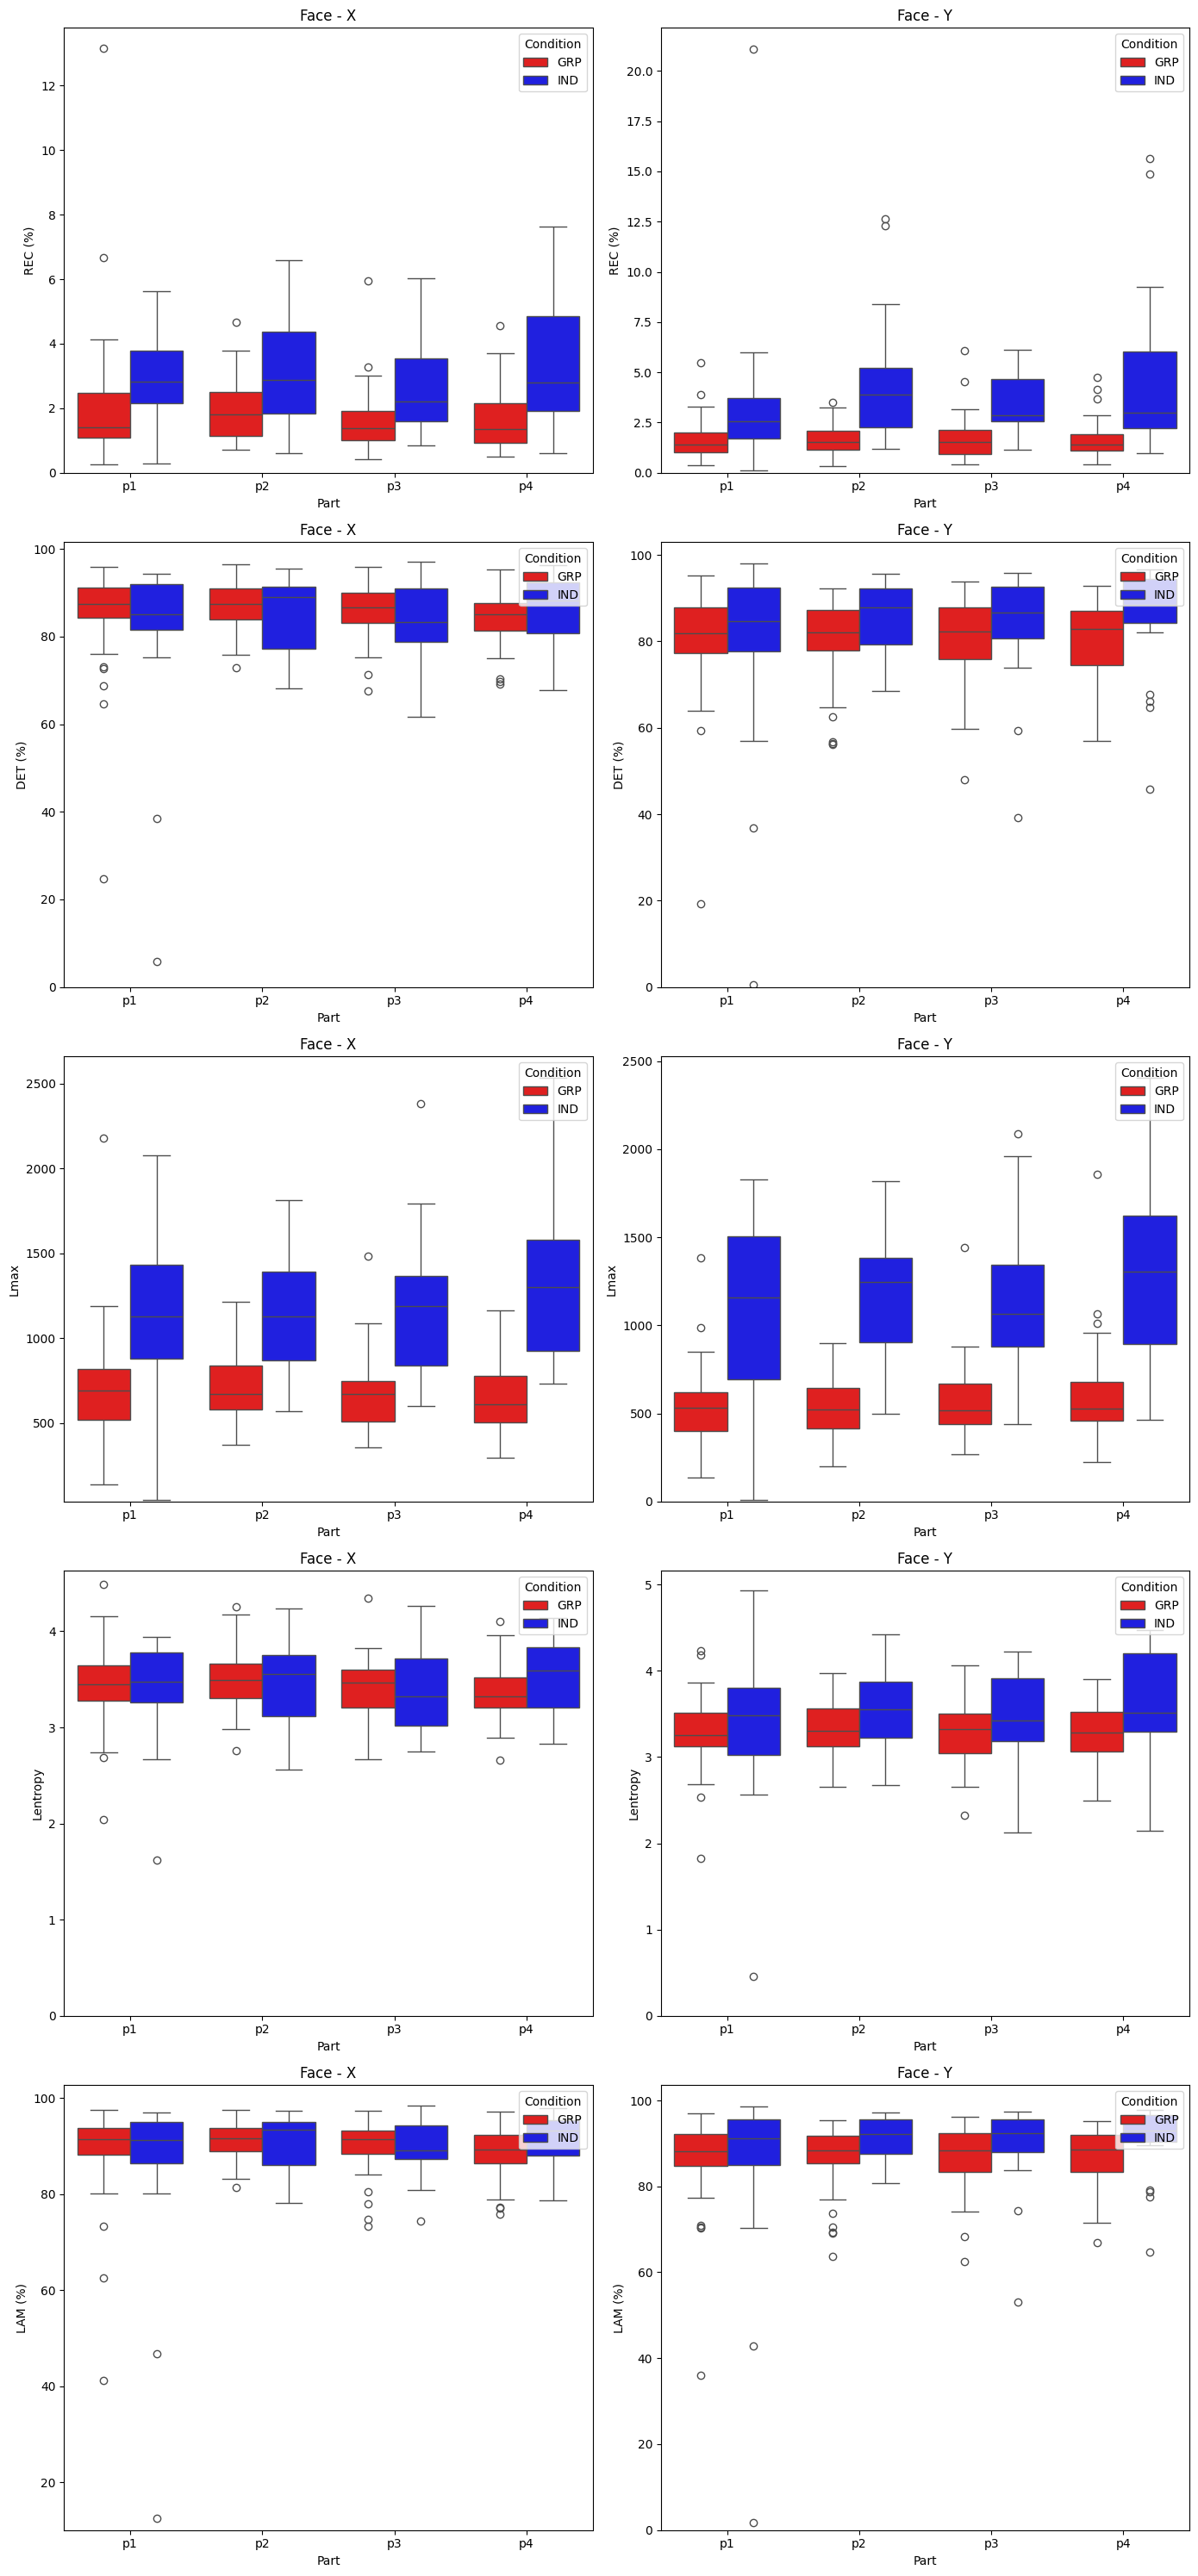

In [13]:
# Set the RQA parameters for the analysis you would like to plot
rqa_params = {
    'delay': 10,
    'embedding_dimension': 3,
    'radius': 0.1,
    'minLine': 5,
    'getRP': False
}

# Set the analysis parameters
analysis_parameters = f"_windowSize{window_size_seconds}s_delay{rqa_params['delay']}_dim{rqa_params['embedding_dimension']}_radius{rqa_params['radius']}_minLine{rqa_params['minLine']}"

# Load the analysis results from the CSV file
csv_file = f'analysis/rqa/lostAtSea_RqaAnalysis{analysis_parameters}.csv'  # Update this path to the correct file
data = pd.read_csv(csv_file)

# Ensure the 'condition' column has correct values
data['condition'] = data['condition'].str.replace('.csv', '')

#------------------------------------------------------------------------------------
# REMOVE STRANGE DATA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#!!!!!!! (Hamish / Nic) ?????????????
# There is a GRP_2 condition that should be GRP or removed. Remove it for consistency
data = data[data['condition'] != 'GRP_2']
data = data[data['group_number'] != 408]
#------------------------------------------------------------------------------------

# Specify the metrics to plot
metrics = ['REC', 'DET', 'Lmax', 'Lentropy', 'LAM']  # List of metrics to plot (e.g., recurrence rate, determinism, longest diagonal line length)

# Initialize the plot
plt.figure(figsize=(14, 6 * len(metrics)))

# Loop through each metric and create the plots
for i, metric in enumerate(metrics):
    for j, axis in enumerate(['x', 'y']):
        plt.subplot(len(metrics), 2, i * 2 + j + 1)
        
        # Prepare data for plotting
        plot_data = []
        for col in data.columns:
            if col.endswith(f'_{metric}') and f'_{axis}' in col:
                temp_df = data[[col, 'condition']].copy()
                temp_df.columns = ['value', 'condition']
                temp_df['part'] = col.split('_')[2]  # Extract p1, p2, p3, p4
                plot_data.append(temp_df)

        plot_data = pd.concat(plot_data)

        # Adjust y-axis label and values if the metric is less than 1
        if plot_data['value'].max() < 1:
            plot_data['value'] *= 100  # Convert to percentage
            y_label = f'{metric} (%)'
        else:
            y_label = metric

        sns.boxplot(x='part', y='value', hue='condition', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})
        
        plt.title(f'Face - {axis.upper()}')
        plt.xlabel('Part')
        plt.ylabel(y_label)
        
        # Scale the y-axis to be slightly less than the minimum value observed
        min_val = plot_data['value'].min()
        plt.ylim(bottom=0 if min_val < 10 else min_val * 0.8)

        # Add legend
        plt.legend(title='Condition', loc='upper right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
